**ALUNO:** GUSTAVO ALEXANDRE SOUSA SANTOS

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures 

# Carregando o pacote que contém a função de carregar arquivos Matlab
from scipy.io import loadmat

# Carregando o pacote que contém a função de minimizar uma Função Objetivo 
from scipy.optimize import minimize

%matplotlib inline

# Regressão Logística com Regularização

Nesta parte do trabalho, será implementada a **_Regressão Logística Regularizada_**
para prever se os microchips de uma usina de fabricação passam na garantia
de qualidade (QA). Durante a QA, cada microchip passa por vários testes para
garantir se está funcionando corretamente. Dessa forma, a Gestão de Produto da 
fábrica terá o resultados de teste para alguns microchips em dois testes diferentes. 

A partir desses dois testes, será determinado se os microchips deveriam ser 
aceitos ou rejeitados. Para auxiliar a tomar a decisão, há um conjunto de dados
com resultados de testes anteriores sobre microchips, a partir do qual é possível construir
um modelo de Regressão Logística.

O arquivo **$ex2data2.txt$** contém os dados a serem usados nessa parte do trabalho. A primeira 
coluna corresponde aos resultados do primeiro teste, enquanto que a segunda coluna corresponde
aos resultados do segundo teste. A terceira coluna contém os valores da classe (y = 0 significa 
rejeitado no teste, e y = 1 significa aceito no teste).

## Visualização dos Dados

Para a maioria dos conjuntos de dados do mundo real, não é possível criar um gráfico para 
visualizar seus pontos. Mas, para o conjunto de dados fornecido, isso é possível. Implemente 
um script em _Python_ que produza um gráfico de dispersão $scatter plot$ dos dados fornecidos. 

In [2]:
data = np.loadtxt('am-T2-dados/ex2data2.txt', delimiter=',')
pd.DataFrame(data).head()

,0,1,2
0,0.051267,0.69956,1.0
1,-0.092742,0.68494,1.0
2,-0.213710,0.69225,1.0
3,-0.375000,0.50219,1.0
4,-0.513250,0.46564,1.0


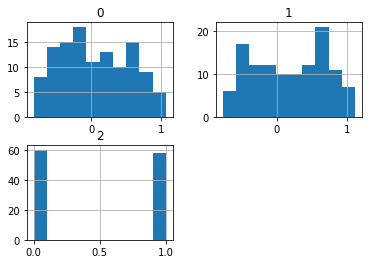

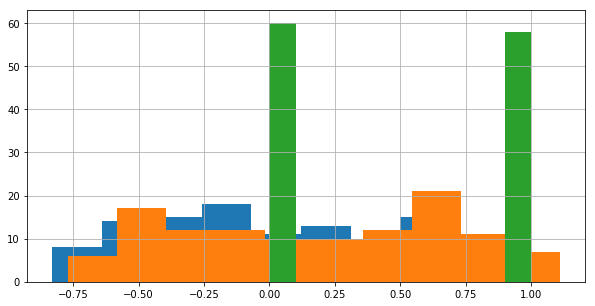

In [3]:
# Visualização da Distribuição dos Dados conforme Histograma
pd.DataFrame(data).hist()
plt.show()

plt.figure(figsize=(10,5))
pd.DataFrame(data)[0].hist(), pd.DataFrame(data)[1].hist(), pd.DataFrame(data)[2].hist()
plt.show();

In [4]:
pd.DataFrame(data).describe().round(2)

,0,1,2
count,118.00,118.00,118.00
mean,0.05,0.18,0.49
std,0.50,0.52,0.50
min,-0.83,-0.77,0.00
25%,-0.37,-0.25,0.00
50%,-0.01,0.21,0.00
75%,0.48,0.65,1.00
max,1.07,1.11,1.00


### Gráfico de Dispersão para Visualização dos dados

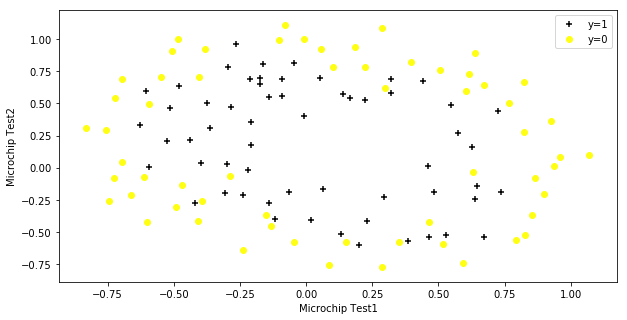

In [5]:
positive = ( data[:, 2] == 1 )  
negative = ( data[:, 2] == 0 )

figura, grafico = plt.subplots(figsize=(10,5))  
grafico.scatter(data[positive][:,0], data[positive][:,1], c='xkcd:black', marker='+', label='y=1')  
grafico.scatter(data[negative][:,0], data[negative][:,1], c='xkcd:yellow', marker='o', label='y=0')  
grafico.legend()  
grafico.set_xlabel('Microchip Test1')  
grafico.set_ylabel('Microchip Test2');

## Mapeamento de características (_feature mapping_)

Uma maneira de tornar os dados mais apropriados para a classificação é criar
mais características a partir das já existentes. Para isso, você deve criar uma
função **`mapFeature`**. Essa função deve ser implementada em um arquivo de
nome **_`mapFeature.py`_**, que irá mapear as características para todos os termos
polinomiais de x1 e x2, até a sexta potência. Como resultado desse mapeamento, nosso 
vetor de duas características (os escores nos dois testes de QA) será transformado 
em um **vetor de _28 dimensões_**.

Um classificador que usa regressão logística treinado nesse vetor de características 
de maior dimensão terá uma fronteira de decisão mais complexa e parecerá não-linear 
quando desenhado em um gráfico bidimensional. 

Embora o mapeamento de características nos permita construir um classificador mais expressivo, 
também é mais suscetível a sobreajuste (overfitting). Desse modo, será implementada a 
**_Regressão Logística Regularizada_** sobre os dados fornecidos e também verá como a regularização pode 
ajudar a combater o problema do sobreajuste.

In [6]:
def mapFeature(X1, X2):
    '''
    Função que mapeia características p/ os termos polinomiais X1 e X2 até a 6ª potência.
    Retorna um novo conjunto com mais características, através do algoritmo de mapping
    X1, X2, X1 ** 2, X2 ** 2, X1*X2, X1*X2 ** 2, etc...
    Os parâmetros X1, X2 devem ser do mesmo tamanho
    '''
    # Potência padrão para o mapeamento
    potencia = 6
    
    X1.shape = (X1.size, 1)
    X2.shape = (X2.size, 1)
    
    features = np.ones(shape=(X1.size, 1))

    for i in range(1, potencia + 1):
        for j in range(i + 1):
            r = (X1 ** (i - j)) * (X2 ** j)
            features = np.append(features, r, axis=1)

    return features

### Testando a Função de Mapeamento de _Features_

In [7]:
A = np.array( pd.DataFrame(data)[0] )
B = np.array( pd.DataFrame(data)[1] )

In [8]:
X_feature = np.c_[mapFeature(A, B)]
X_feature.shape

(118, 28)

## Função de custo e gradiente

Agora, você deverá implementar o código para calcular **_a função de custo e
o gradiente para a regressão logística regularizada_**. Crie um arquivo de nome
costFunctionReg.py que contém uma função de nome costFunctionReg.py
e que computa o custo e o gradiente. Lembre-se de que a função de custo
regularizada na regressão logística é dada por:
    
$$J_{regularizado} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(x^{(i)}\right) + (1-y^{(i)})\log\left(1- x^{(i)}\right) \large{)} }_\text{Função de Custo} + \underbrace{\frac{\lambda}{2m} \sum\limits_{j = 1}^{n}\ {\theta}_{j}^{2} }_\text{Fator Regularização} $$
    
Depois de concluir a implementação da função **costFunctionReg**, você deve
testar a corretude dela usando o valor inicial de ${\theta}$ (inicializado todo com zeros).
Você deve ver que o custo é de cerca de `0.693`.
Porém, usando a função **costFunctionReg**, você agora deve computar os valores ótimos para ${\theta}$.

In [9]:
def sigmoid(x):
    '''
    A função sigmoid
    '''
    g = np.array([x]).flatten()
    s = 1 / (1 + np.exp(-x))
    return s

In [10]:
def minFunction(theta, Lambda, X, y):
    '''
    Função de minimização sobrescrita  p/ atender à Função Objetivo 
    'costFunctionReg' e com o a aplicação de gradiente 'gradientReg'
    '''
    
    M = minimize(costFunctionReg, theta, args=(Lambda, X, y), jac=gradientReg, options={'maxiter':3000})
    print('Custo de Minimização da Função: ', np.round(M.fun, 4))
    print('Custo da Função: ',M.status)
    print('Nº de Iterações necessárias: ',M.nit)
    print('Êxito de Otimização: ',M.message)
    return M

In [11]:
def costFunctionReg(theta, X, y, alpha): 
    '''
    A versão do GD que acabamos de estudar é denominada *Batch gradienteient Descent*.
    Em cada iteração do algoritmo, todo o conjunto de treinamento é utilizado.

        X = características (features)
        y = alvo (target)
        Lambda = Taxa de regularização
    '''
    
    m = y.size
    h = sigmoid(X.dot(theta))
    Reg = (alpha/(2*m))*np.sum(np.square(theta[1:]))
    J = -1*(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) + Reg 
    
    if np.isnan(J[0]): return(np.inf)
    
    return(J[0])

In [12]:
def gradientReg(theta, X, y, alpha):
    
    m = y.size
    h = sigmoid(X.dot(theta.reshape(-1,1)))
    Reg = (alpha/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
    grad = (1/m)*X.T.dot(h-y) + Reg
        
    return np.c_[grad]

### Testando a Função de Custo e o Gradiente

In [13]:
# Concatenando os valores de y de forma vetorizada

y_feature = np.c_[pd.DataFrame(data)[2]]

print('Dimensionamento do y: '+str(y_feature.shape))
print('Dimensionamento do X: '+str(X_feature.shape))

Dimensionamento do y: (118, 1)
Dimensionamento do X: (118, 28)


In [14]:
# Avaliando a Função de Custo Regularizada

theta0 = np.zeros(X_feature.shape[1])
costFunctionReg(theta0, X_feature, y_feature, 1)

0.69314718055994529

In [15]:
# Avaliando a Gradiente Regularizado

theta0 = np.zeros(X_feature.shape[1])
grad = gradientReg(theta0, X_feature, y_feature, 1)
grad.shape

(28, 1)

## Esboço da fronteira de decisão

Nessa parte, você deve esboçar (plotar) a fronteira de decisão que foi aprendida
para separar os exemplos positivos dos negativos. Crie uma arquivo de nome
**``plotDecisionBoundary.py``**, para criar esse gráfico que traça o limite da decisão
não-linear. Seu gráfico deve ser semelhante ao apresentado na **_Figura_** abaixo.

![ScatterBoundaryPlot](scatter_boundary.jpg)

In [16]:
def plotDecisionBoundary(data, grad, LAMBDA):
    ''' 
    Função que deve esboçar um Gráfico de Dispersão com a sua Fronteira de Decisão.
    '''
    
    X = data[:,0:2]
    y = np.c_[data[:,2]]
    #theta = np.zeros(X_feature.shape[1])
    
    X_poli = PolynomialFeatures(6)
    X_fit = X_poli.fit_transform(X)
    #FMIN = minFunction(theta, 1, X_fit, y)
    
    # Plot decisionboundary
    X0_min, X0_max = X[:,0].min(), X[:,0].max()
    X1_min, X1_max = X[:,1].min(), X[:,1].max()
    X0, X1 = np.meshgrid(np.linspace(X0_min, X0_max), np.linspace(X1_min, X1_max))
    
    h = sigmoid(X_poli.fit_transform(np.c_[X0.ravel(), X1.ravel()]).dot(grad))
    #h = sigmoid((np.c_[X0.ravel(), X1.ravel()]).dot(grad))
    h = h.reshape(X0.shape)

    # Scatter plot of X,y and Get indexes for class 0 and class 1
    neg = data[:,2] == 0
    pos = data[:,2] == 1

    # If no specific axes object has been passed, get the current axes
    plt.figure(figsize=(10,5))
    plt.contour(X0, X1, h, [0.5], linewidths=3, colors='g', s=60, label='Decision boundary'); 
    plt.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label='y=1')
    plt.scatter(data[neg][:,0], data[neg][:,1], marker='o', c='y', s=60, linewidth=2, label='y=0')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')      
    plt.title('Lambda = '+str(LAMBDA))
    plt.legend(loc=1);

### Avaliando o Gráfico da fronteira de decisão

    A geração do Gráfico da Fronteira de decisão está falhando ao criar o objeto de Contorno. Por inúmeros testes nesse caso, eu acredito que o meu problema esteja relacionado na utilização na Função de Minimização do Pacote Optimize.

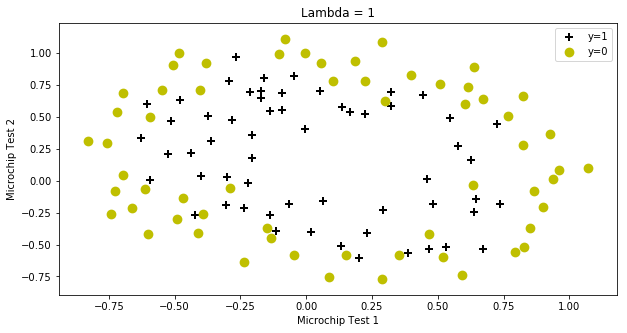

In [17]:
plotDecisionBoundary(data, grad, 1)

# Regressão Linear com Regularização

Na primeira metade desta parte, você implementará a regressão linear com regularização para prever a quantidade de água fluindo de uma barragem usando a mudança do nível da água em um reservatório. Na próxima metade, você realizará diagnósticos dos algoritmos de aprendizado por meio de depuração e irá examinar os efeitos de viés (_bias_) e da variância (_variance_).

Você irá usar o dataset fornecido no arquivo **ex5data1.mat$^1$**. Nesse arquivo há registros históricos na mudança no nível da água, _x_, e da quantidade de água que sai da barragem, _y_. Este conjunto de dados é dividido em três partes:
 - Um conjunto de treinamento que seu modelo aprenderá em: _**X**_, _**y**_
 - Um conjunto de validação cruzada para determinar o parâmetro de regularizacão: _**Xval**_, _**yval**_
 - Um conjunto de testes para avaliar o desempenho. Estes são exemplos que seu modelo não irá usar durante o treino: _**Xtest**_, _**ytest**_

Os nomes das variáveis contidas no arquivo **ex5data1.mat** são os seguintes: _X_, _Xtest_, _Xval_, _y_, _ytest_, _yval_. Você irá precisar desses nomes para carregar os dados do arquivo para usar em seus scripts em Python.

_____________________________________
$^1$ Arquivos com a extensão **_.mat_** são normalmente criados no **Octave** ou no **Matlab**. Para
carregar esse arquivo no Python, você pode usar o procedimento descrito em <http://www.
blogforbrains.com/blog/2014/9/6/loading-matlab-mat-data-in-python>

In [18]:
dataMatlab = loadmat('am-T2-dados/ex5data1.mat')
dataMatlab.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

## Visualização dos Dados

Você deve começar por produzir uma visualização do conjunto de dados de treinamento. O gráfico que você deve produzir deve ser similar ao apresentado na Figura abaixo:

![scatter_trainning.jpg](scatter_trainning.jpg)

##############################################################################
Os Conjuntos de Treinamento e Validação: 
	X_train: (12, 2)
	y_train: (12, 1)
	X_test: (21, 2)
	y_test: (21, 1)
	Xval: (21, 2)
	yval: (21, 1)
##############################################################################


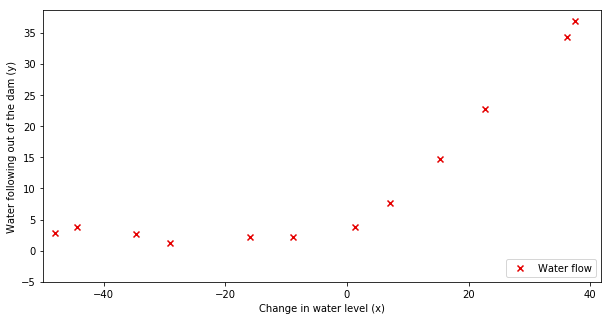

In [19]:
# Obtendo o conjunto de treinamento para a Visualização Gráfica
y_treino = dataMatlab['y']
X_treino = np.c_[np.ones_like(dataMatlab['X']), dataMatlab['X']]

y_teste = dataMatlab['ytest']
X_teste = np.c_[np.ones_like(dataMatlab['Xtest']), dataMatlab['Xtest']]

y_valida = dataMatlab['yval']
X_valida = np.c_[np.ones_like(dataMatlab['Xval']), dataMatlab['Xval']]

print('##############################################################################')
print('Os Conjuntos de Treinamento e Validação: ')
print('\tX_train:', X_treino.shape)
print('\ty_train:', y_treino.shape)
print('\tX_test:', X_teste.shape)
print('\ty_test:', y_teste.shape)
print('\tXval:', X_valida.shape)
print('\tyval:', y_valida.shape)
print('##############################################################################')

plt.figure(figsize=(10,5))
plt.scatter(X_treino[:, 1], y_treino, c='xkcd:red', marker='x', label='Water flow')
plt.xlabel('Change in water level (x)')  
plt.ylabel('Water following out of the dam (y)')
plt.ylim(ymin=-5)
plt.xlim(xmin=-50)
plt.legend(loc=4);

## Função de Custo de Regressão Linear Regularizada

Lembre-se de que a regressão linear regularizada tem a seguinte função de custo:

$$\large J_{\theta} = \small {\frac{1}{2m} \sum\limits_{i = 1}^{m} \large{[}\small h_{\theta}\left((x^{(i)}) - y^{(i)}\right)^{2} \large{]} } + {\frac{\lambda}{2m} \sum\limits_{j = 1}^{n}\ {\theta}_{j}^{2} } $$


Lembre-se de quê um hyperparâmetro que controla o grau de regularização (e assim, ajuda a prevenir o excesso de sobreajuste). O termo de regularização impõe uma penalidade sobre o custo total $\large J_{\theta}$. Conforme as magnitudes dos parâmetros do modelo J aumentam, a penalização aumenta também. Note que você não deve regularizar o termo **${\theta}$**.

Sua tarefa é escrever uma função para calcular a função de custo da regressão linear regularizada. Você deve implementar esse código em um arquivo de nome ${linearRegCostFunction.py}$. Se possível, tente vetorizar seu código e evitar o uso de _loops_. Quando você tiver completado a implementação, verifique a corretude da sua função de custo usando ${\theta}$ inicializado com (1, 1). Você deve esperar ver uma saída de _303.993_.

In [20]:
def linearRegCostFunction(theta, X, y, Lambda):
    '''

        theta = conjunto de pesos
        X = características (features)
        y = alvo (target)
        Lambda = Taxa de regularização
    '''
    
    m = y.size
    H = X.dot(theta)
    J = (1/(2*m)) * np.sum(np.square(H-y)) 
    Reg = (Lambda/(2*m)) * np.sum(np.square(theta))
   
    return J+Reg

In [21]:
def linearRegGradient(theta, X, y, Lambda):
    '''

        theta = conjunto de pesos
        X = características (features)
        y = alvo (target)
        Lambda = Taxa de regularização
    '''
    
    m = y.size
    h = X.dot(theta.reshape(-1,1))
    Reg = (Lambda/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
    grad = (1/m)*(X.T.dot(h-y))+ Reg 
        
    return grad.flatten()

In [22]:
X_treino.shape

(12, 2)

In [23]:
theta0 = np.ones((X_treino.shape[1],1))
cost = linearRegCostFunction(theta0, X_treino, y_treino, 0)
print(cost)

303.951525554


## Gradiente na regressão linear regularizada

A derivada parcial do gradiente da função de custo da regressão linear regularizada é um vetor no qual o *j-ésimo* elemento.

No arquivo $linearRegCostFunction.py$, adicione código para calcular o gradiente. Quando você tiver completado essa implementação, teste a corretude usando $theta$ inicializado em $(1, 1)$. Você deve esperar ver um gradiente de $(-15.30, 598.250)$.

In [24]:
theta0 = np.ones((X_treino.shape[1],1))
gradient = linearRegGradient(theta0, X_treino, y_treino, 0)
print(gradient)

[ -15.30301567  598.16741084]


## Ajustando os parâmetros da regressão linear

Nesta parte, use a função **linearRegCostFunction** para computar os valores ótimos para $\theta$, mas sem usar regularização, i.e., defina $\lambda$ = 0. Após isso, construa um gráfico para visualiar o modelo construído. Seu gráfico deve ser similar ao apresentado na Figura abaixo.

![plot_linear.jpg](plot_linear.jpg)

In [25]:
def trainLinearReg(theta, X, y, Lambda):
    '''
    Função para mininzar a Função de Custo 'linearRegCostFunction' com Gradiente 'linearRegGradient'.
        theta = conjunto de pesos
        X = características (features)
        y = alvo (target)
        Lambda = Taxa de regularização
    '''
 
    M = minimize(linearRegCostFunction, theta, args=(X,y,Lambda), jac=linearRegGradient, options={'maxiter':5000})
    
    return M

### Caso 1:  Função de Minimização não convergiu com $\large \theta$ = array([[ 1.],[1.]])

 - Quando inicializamos o theta com valores 1, não houve sucesso na minimização.

In [26]:
theta0 = np.ones((X_treino.shape[1],1))
fit = trainLinearReg(theta0, X_treino, y_treino, 0)
fit

      fun: 1285.0884851841522
 hess_inv: array([[ 1.02731204,  0.00634135],
       [ 0.00634135,  0.00120857]])
      jac: array([ -3.6472391, -92.1177481])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 102
      nit: 3
     njev: 90
   status: 2
  success: False
        x: array([ 8.75688344,  0.2333203 ])

### Caso 2: Função de Minimização somente convergiu com  $\large \theta$ = array([[15],[15]])

- Quando inicializamos o theta com valores 15, houve sucesso na minimização.

In [27]:
theta0 = np.array([[15],[15]])
fit = trainLinearReg(theta0, X_treino, y_treino, 0)
fit

      fun: 1604.4002999186634
 hess_inv: array([[ 1.03142187,  0.00617881],
       [ 0.00617881,  0.001215  ]])
      jac: array([  3.42437190e-12,  -5.70370264e-10])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([ 13.08790351,   0.36777923])

### Avaliação do Treinamento: $trainLinearReg$ VS $sklearn.LinearRegression$

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

regr = LinearRegression(fit_intercept=False)
regr.fit(X_treino, y_treino.ravel())
print('trainLinearReg :' +str(regr.coef_) )
print('LinearRegression :' +str(fit.x) )

trainLinearReg :[ 13.08790351   0.36777923]
LinearRegression :[ 13.08790351   0.36777923]


### Gráfico Modelado com Regressão Linear Regularizada

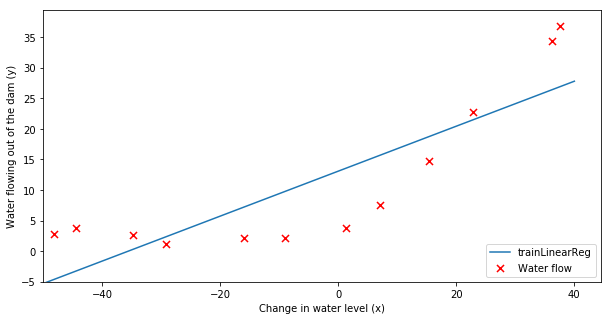

In [29]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(-50,40), (fit.x[0]+ (fit.x[1]*np.linspace(-50,40))), label='trainLinearReg')
plt.scatter(X_treino[:,1], y_treino, s=50, c='r', marker='x', linewidths=2, label='Water flow')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.ylim(ymin=-5)
plt.xlim(xmin=-50)
plt.legend(loc=4);

# Viés-Variância

Um conceito importante no Aprendizado de Máquina é o relacionamento entre o **viés (bias) e a variância (variance)** de um modelo de aprendizado. Modelos com viés elevado não são suficientemente complexos para os dados e tendem a sofrer de subajuste (underfitting), enquanto que modelos com alta variância tendem a sofrer de sobreajuste.

Nesta parte do trabalho, você irá produzir gráficos dos erros de treinamento e teste na forma de curvas de aprendizado para diagnosticar problemas de **_viés-variância_**.

## Curvas de Aprendizado

Agora você implementará código para gerar as curvas de aprendizado que serão úteis na depuração de algoritmos de aprendizagem. Lembre-se de que uma curva de aprendizagem traça erros de treinamento e de validação cruzada como funções do tamanho do conjunto de treinamento. Crie um arquivo de nome **learningCurve.py** que deve conter uma função (também chamada $learningCurve$) que retorna um vetor de erros para o conjunto de treinamento e conjunto de *validação cruzada*.

Para traçar a curva de aprendizado, precisamos de um conjunto de treinamento e validação cruzada erro para diferentes tamanhos de conjuntos de treinamento. Para obter diferentes tamanhos de conjuntos de treinamento, você deve usar subconjuntos diferentes do conjunto de treinamento original **X**. Especificamente, para um tamanho de conjunto de treinamento de $i$, você deve usar os primeiros exemplos de i (ou seja, _**X**(1 : i; :)_ e _**y**(1 : i)_).

Para cada tamanho de conjunto de treinamento, você encontrar os parâmetros $\theta$. Note que o $lambda$ deve ser passado como um parâmetro para a função $learningCurve$. Depois de aprender os parâmetros $\theta$, você deve calcular o erro nos conjuntos de treinamento e de validação. Lembre-se de que o erro de treinamento para um conjunto de dados é definido como:

Em particular, note que o erro de treinamento não inclui o termo de regularização. Uma maneira de calcular o erro de treinamento é usar a sua função de custo já implementada e definir $\lambda$ = 0 apenas para calcular o erro de treinamento e o erro de validação cruzada. Quando você estiver computando o erro no conjunto de treinamento, certifique-se de computá-lo no subconjunto de treinamento (ou seja, _**X**(1 : n; :)_ e _**y**(1 : n)_), em vez de usar todo o conjunto de treinamento). No entanto, para o erro de validação cruzada, você deve calculá-lo usando todo o conjunto de validação cruzada. Você deve armazenar os erros calculados em dois vetores. 

Quando você estiver terminado o que foi descrito acima, imprima as curvas de aprendizado e produza um gráfico similar ao apresentado na Figura abaixo.

![plot_train.jpg](plot_train.jpg)

Na curva que você irá produzir, você poderá observar que os erros de treinamento e de validação cruzada s~ao ambos altos quando o número de exemplos de treinamento é aumentado. Isso reflete o viés alto do modelo (o modelo de
regressão linear é muito simples e não consegue se ajustear bem ao conjunto de dados). Na próxima seção, você irá implementar regressão polinomial para ajustar um modelo melhor a este conjunto de dados.


In [30]:
def learningCurve(X_treino, y_treino, X_valida, y_valida, Lambda):
    '''
    Função que retorna um vetor de erros para o conjunto de treinamento e conjunto de validação cruzada.
        Conjunto de treinamento: X_treino, y_treino
        Conjunto de validação: X_valida, y_valida
        Lambda = 0
    '''
    
    theta0 = np.array([[15],[15]])
    m = y_treino.size
    Erro_treino = np.zeros((m, 1))
    Erro_valida = np.zeros((m, 1))
    
    for i in np.arange(m):
        TR = trainLinearReg(theta0, X_treino[:i+1], y_treino[:i+1], Lambda)
        Erro_treino[i] = linearRegCostFunction(TR.x, X_treino[:i+1], y_treino[:i+1], Lambda)
        Erro_valida[i] = linearRegCostFunction(TR.x, X_valida, y_valida, Lambda)
    
    return(Erro_treino, Erro_valida)

### Testando a Função de Curvas de Aprendizado 

In [31]:
Erro_treino, Erro_valida = learningCurve(X_treino, y_treino, X_valida, y_valida, 0)
print(Erro_treino)
print(Erro_valida)

[[  8.87468518e-31]
 [  4.61809566e-01]
 [  7.03694242e+02]
 [  1.14419271e+03]
 [  1.28992654e+03]
 [  1.38750307e+03]
 [  1.36542539e+03]
 [  1.46345650e+03]
 [  1.46740034e+03]
 [  1.48802029e+03]
 [  1.46024924e+03]
 [  1.60440030e+03]]
[[ 8535.69120495]
 [ 2778.99137362]
 [ 4375.516645  ]
 [ 4576.68063807]
 [ 3612.77578886]
 [ 3620.49134089]
 [ 3450.74926653]
 [ 3340.37076697]
 [ 3281.63342101]
 [ 3011.56894994]
 [ 2932.99290931]
 [ 2958.19686606]]


### Gráfico de Curvas de Aprendizado

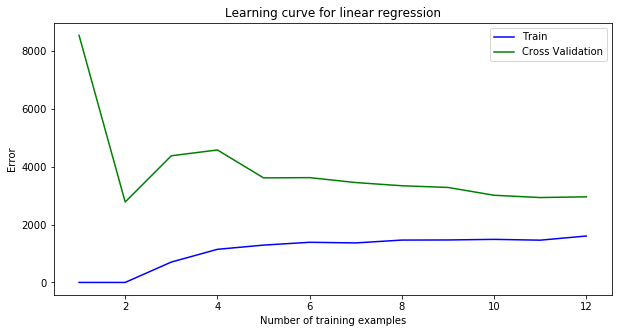

In [32]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,13), Erro_treino, c='blue', label='Train')
plt.plot(np.arange(1,13), Erro_valida, c='green', label='Cross Validation')
plt.title('Learning curve for linear regression')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend(loc=1);

# Regressão Polinomial

O problema com nosso modelo linear é que ele é muito simples para os dados e resultou em subajuste (*viés alto*). Nesta parte, você irá resolver esse problema adicionando mais características. Para usar a regressão polinomial, defina uma hipótese da seguinte forma:

$$H_{\theta}(x) = \theta_{0} + \theta_{1} * waterLevel + \theta_{2} * waterLevel^{2} + ... + \theta_{p} * waterLevel^{p}$$.

Observe que, ao definir $x_{1} = (WaterLevel)$, $x_{2} = (WaterLevel)^{2}$, ... , $x_{p} = (WaterLevel)^{p}$, obtemos um modelo de regressão linear onde os características são as diferentes pontências do valor original $(WaterLevel)$. Agora, você irá adiciona mais características usando as pontências da característica existente x no conjunto de dados. Sua tarefa nesta parte é implementar código em um arquivo de nome **polyFeatures.py**. Nesse arquivo, crie um função de mesmo nome que mapeie o conjunto de treinamento original $X$ de tamanho $m$ $x$ $1$ em suas potências mais altas. Especificamente, quando um conjunto de treinamento $X$ de tamanho $m$ $x$ $1$ for passado para essa função, ela deve retornar uma matriz $m$ $x$ $p$ de nome $X_poli$, onde a coluna 1 contém os valores originais de $X$, a coluna $2$ contém os valores de $x^{2}$, a coluna 3 contém os valores de $x^{3}$, e assim por diante. Note que você não tem que considerar a potência de expoentezero nessa função. Após implementar o descrito acima, você terá uma função que mapeia características para uma maior dimensão.

In [33]:
def polyFeatures(X, p):
    '''
    Função que mapeie o conjunto de treinamento X de tamanho M x 1 em n-ésima potência.
    '''

    X_poly = X
    if p >= 2:
        for k in range(1,p):
            X_poly = np.column_stack((X_poly, np.power(X,k+1)))
            
    return X_poly

In [34]:
def normalizaFeatures(X):
    '''
    Função que calcula a normalizada para cada elemento, dado um vetor. 
    '''
    
    mu = np.mean(X, axis=0)
    X_norm = X - mu

    sigma = np.std(X_norm, axis=0)
    X_norm = X_norm/sigma

    return X_norm, mu, sigma

## Preparação para a $Tarefa$ $de$ $Aprendizado$

In [35]:
# Obtendo os conjuntos de Teste, Treino e Validação para a Tarefa de Aprendizado
y = dataMatlab['y']
X = dataMatlab['X']

ytest = dataMatlab['ytest']
Xtest = dataMatlab['Xtest']

yval = dataMatlab['yval']
Xval = dataMatlab['Xval']


print('X:', X.shape)
print('y:', y.shape)
print('Xtest:', Xtest.shape)
print('ytest:', ytest.shape)
print('Xval:', Xval.shape)
print('yval:', yval.shape)

X: (12, 1)
y: (12, 1)
Xtest: (21, 1)
ytest: (21, 1)
Xval: (21, 1)
yval: (21, 1)


# Regressão Polinomial - aprendizado

Depois de ter completado **polyFeatures.py**, você deve treinar um modelo de regressão polinomial usando sua função de custo da regressão linear. Tenha em mente que, apesar de termos termos polinomiais no vector de características, ainda estamos resolvendo um problema de otimização de regressão linear. Os termos polinomiais simplesmente se transformaram em características que podemos usar para aplicar regressão linear. Estamos usando a mesma função de custo e gradiente que você implementou para a parte anterior deste trabalho.

Para esta parte do trabalho, você usará um polinômio de grau 8. Se executarmos o treinamento diretamente sobre os dados projetados, não iremos obter um bom resultado, porque as características não irão estar na mesma escala (por exemplo, um exemplo com x = 40 agora terá uma característica $x^{8} = 40^{8} = 6.5 \times 10^{1} 2 $). 

Portanto, você vai precisar aplicar a normalização de características. Portanto, antes de aprender os parâmetros $\theta$ para a regressão polinomial, você deve normalizar as características do conjunto de treinamento, e armazenar os parâmetros $\mu$ e $\sigma$. Depois de aprender os parâmetros $\theta$, você deve ver gerar dois gráficos (que devem ser similares aos das $Figuras$ abaixo) gerados com a regressão polinomial com $\lambda$ = 0.

![plot_polinomial.jpg](plot_polinomial.jpg)

## Tarefa de Aprendizado com as Funções $polyFeatures$ e $normalizaFeatures$

In [36]:
p = 8
m = X.shape[0]

X_poly = polyFeatures(X, p)
X_poly, mu, sigma = normalizaFeatures(X_poly)  
X_poly = np.column_stack((np.ones((m,1)), X_poly))

X_poly_test = polyFeatures(Xtest, p)
X_poly_test = (X_poly_test - mu) / sigma
X_poly_test = np.column_stack((np.ones((X_poly_test.shape[0],1)), X_poly_test)) # Add Ones

X_poly_val = polyFeatures(Xval, p)
X_poly_val = (X_poly_val - mu) / sigma
X_poly_val = np.column_stack((np.ones((X_poly_val.shape[0],1)), X_poly_val)) # Add Ones

print('Normalized Training Example 1 ')
print(X_poly[0, :])

Normalized Training Example 1 
[ 1.         -0.3782437  -0.78866232  0.19032872 -0.7375913   0.32025197
 -0.6171516   0.35983501 -0.53109126]


Da *Figura acima*, você deve perceber que o polinômio pode se ajustar aos pontos de dados muito bem, obtendo um baixo erro de treinamento. No entanto, o polinômio é muito complexo e até mesmo despenca nos extremos. Isso é um indicador de que o modelo de regressão polinomial está se ajustando demasiadamente aos dados de treinamento e que não irá generalizar bem. 

![plot_curva_aprendizado.jpg](plot_curva_aprendizado.jpg)

Para entender melhor os problemas com o modelo não regularizado ($\lambda$ = 0), você pode ver que a curva de aprendizado (na *Figura acima* ) apresenta erro de treinamento baixo, mas erro de validação alto. Há uma lacuna entre os erros de treinamento e validação cruzada, indicando um problema de variância alta.

# Tarefas adicionais (Opcionais)

Ajuste do parâmetro de regularização. Teste o aprendizado para diferentes valores de lambda, $1 \le \lambda \le 100$. Para $\lambda = 1$, você deve ver o polinômio segue a tendência de dados bem e uma curva de aprendizado ($Figuras$ acima) mostrando que tanto o erro de validação quanto o erro de treinamento convergem para um valor relativamente baixo. Isso mostra que o modelo de regressão polinomial regularizado com $\lambda = 1$ não sofre dos problema de viés alto ou de variância alta. De fato, esse modelo alcança um bom compromisso entre viés e variância. Para $\lambda = 100$, você deve ver um polinômio ($Figura$ abaixo) que não segue os dados bem. Neste caso, há muita regularização, e o modelo é incapaz de se ajustar aos dados de treinamento.

Defina o valor de $\lambda$ usando o conjunto de validação. Implemente um método automatizado para selecionar o parâmetro $\lambda$. Concretamente, use um conjunto de validação cruzada para avaliar quão bom é cada valor de $\lambda$. Ao realizar essa tarefa, você deve encontrar um valor adequado de $\lambda$ em torno de 3 (veja a $Figura$ abaixo). Tente valores de $\lambda$ no intervalo $ \left[0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10\right] $.

Depois de selecionar o melhor valor de $\lambda$ usando o conjunto de validação, você pode então avaliar o modelo no conjunto de teste para estimar o quão bem ele será executado em dados reais não vistos.
 
![plot_lambda.jpg](plot_lambda.jpg)